# Project2 - ENPM673

#### Name = Tathya Bhatt
#### UID - 120340246

# Part1 - Boundary Detection

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

### Capturing Video

In [ ]:
vid_cap = cv2.VideoCapture("proj2_v2.mp4")

### Checking the number of frames

In [ ]:
frame_count = vid_cap.get(7)
print('Frame count : ', frame_count)

Frame count :  386.0


### Converting to Binary Frame

In [ ]:
def convert2bin(frame):
  binary_mask = (frame > 200) * 255

  return binary_mask.astype(np.uint8)

### Defining Gaussian Kernel

Gaussian Filter is applied to the image to basically smoothen the image and extract necessary edges from the filtered image.

The formula for Gaussian Kernel is as follows:

$$
f(x, y) = A \cdot e^{-\left( \frac{(x - x_0)^2}{2 \sigma_x^2} + \frac{(y - y_0)^2}{2 \sigma_y^2} \right)}
$$


Here $ \sigma_x,  \sigma_y $ are the variance terms and determine the spread of the function in x and y direction.

In [ ]:
def gauss_kernel(kernel, sigma):
    size = int(kernel//2)
    variance = sigma ** 2
    x,y = np.mgrid[-kernel:kernel + 1, -kernel:kernel+1]
    norm = 1/ (2 * np.pi * variance)
    g = np.exp(-((x**2 + y**2)/(2*variance))) * norm

    return g


### Defining Laplacian Kernel

Laplacian kernel as instructed will be used to filter out the blurred frames by taking the variance of the image after applying the laplacian filter.

In [ ]:
lap_kernel = np.array([[0,1,0],
                       [1,-4, 1],
                       [0,1,0]])

### Main Pipeline


1. The code reads frames from a video file called "proj2_v2.mp4" using OpenCV's VideoCapture object. It processes each frame and writes the result to an output video file named "final_video_.mp4" using a VideoWriter object.

2. The code processes each frame of the input video individually. It employs multiple image processing methods including grayscale conversion, Gaussian blur, and Canny edge detection to identify edges within the frame.

3. For Boundary Detection, the Hough transform **cv2.HoughLinesP** is used to identify **line segment instead of infinte lines** in the frames processed with edge detection. The lines are detected based on the endpoints provided by the function. These detected lines are then visualized on the frame using OpenCV's **cv2.line** functions and are denoted in **Blue** Color.

4. To find the putative corners, the code computes intersections among pairs of lines identified by the Hough transform. It filters the intersection points considering the angles and distances between these lines. These points are then denoted by **Red Circles** on the paper


5. To valid the intersection points, Harris corner detection algorithm **cv2.cornerHarris** to identify corners in the frame. Detected corners are highlighted with **green color** on the frame, which might me visible in some frames.



In [ ]:
vid_cap = cv2.VideoCapture("proj2_v2.mp4")

# Making an output video object
output_vid = 'final_video_.mp4'

# Four Char Code for Video Format of "mp4v"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# Setting the FPS of output video to 10 as instructed
fps = 10.0

# Getting the frame width and height
frame_width = int(vid_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(vid_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))


output_vid_write = cv2.VideoWriter(output_vid, fourcc, fps, (frame_width, frame_height))

# Checks if the source video is opened or not
if vid_cap.isOpened()==False:
    print("Cannot open the file")

# Initializing the blurred frames counter
frame_discard = 0
# Giving the variance threshold to detect blurry frames
lap_thresh = 50

# Setting the threshold values to filter the intersection of hough lines and discard the unwanted intersections
min_dist_thresh= 0.0
max_dist_thresh = 200.0
min_ang_thresh = 0.0
max_ang_thresh = 90.0

# If the video is opened, perform the required manipulation step by step to each frame.
while (vid_cap.isOpened()):

    ret,frame = vid_cap.read()

    if ret == True:
        # Converting a RGB image to GrayScale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Applying gaussian blur using the gaussian kernel of size 3x3 and sigma as 1
        gauss_blur = cv2.filter2D(frame, -1, gauss_kernel(3,1))

        # Converting the result frame to binary
        bw_img = convert2bin(gauss_blur)

        # Taking the variance of the laplacian applied on gray frame and converting it to int
        var_img = cv2.filter2D(gray, -1, lap_kernel).var().astype(int)
        # print(var_img)

        # Aplying an if condition to skip the blurry frames
        if var_img < lap_thresh:
            frame_discard = frame_discard + 1
            continue
        else:

            # Applying Canny Edge Detection to the binary image
            edges = cv2.Canny(bw_img, 240, 255)
            # Using probabilistic method for hough lines
            hough_lines = cv2.HoughLinesP(edges, 1, np.pi/180, 85, minLineLength=100, maxLineGap=10)
            # Determing the corners of paper using Corner Harris
            corners = cv2.cornerHarris(gray, 3, 7, 0.05)
            corners = cv2.dilate(corners,None)
            # Filtering out the required corners and making them green
            frame[corners>0.4*corners.max()]=[0,255,0]

            # Drawing hough lines by getting the vertices of two points and using cv2.line
            if hough_lines is not None:
                for line in hough_lines:
                    # print(line)
                    x_1h, y_1h, x_2h, y_2h = line[0]
                    cv2.line(frame, (x_1h, y_1h), (x_2h, y_2h), (255, 0, 0), 2)

            # To find the intersections of hough lines
            if hough_lines is not None:
                for i in range(len(hough_lines)):
                    for j in range(i+1, len(hough_lines)):
                        # Points for line 1
                        x_1, y_1, x_2, y_2 = hough_lines[i][0]
                        # Points for line 2
                        x_3, y_3, x_4, y_4 = hough_lines[j][0]
                        # print(x_1, x_2, x_3, x_4)
                        # Calculating the intersection points
                        denom_frac = (x_1 - x_2)*(y_3 - y_4) - (y_1 - y_2)*(x_3 - x_4)
                        if denom_frac != 0:
                            # Determining numerator of x and y
                            x_frac = (x_1*y_2 - y_1*x_2)*(x_3 - x_4) - (x_1 - x_2)*(x_3*y_4 - y_3*x_4)
                            y_frac = (x_1*y_2 - y_1*x_2)*(y_3 - y_4) - (y_1 - y_2)*(x_3*y_4 - y_3*x_4)
                            x = int(round(x_frac / denom_frac))
                            y = int(round(y_frac / denom_frac))

                            # Determining the distance between intersection points and the lines
                            dist1 = np.sqrt((x - x_1)**2 + (y - y_1)**2)
                            # print("distance1", distance_1)
                            dist2 = np.sqrt((x - x_3)**2 + (y - y_3)**2)

                            # Determining the angle between two lines
                            ang1 = np.arctan2(y_2 - y_1, x_2 - x_1) * 180 / np.pi
                            # print("Angle1",angle_1)
                            ang2 = np.arctan2(y_4 - y_3, x_4 - x_3) * 180 / np.pi
                            # print("Angle2",angle_2)

                            # Gives the corners if the angle formed between two lines is between that threshold and if distance between intersection points and hough lines lies between the minimum and maximum threshold
                            if min_ang_thresh < ang1 < max_ang_thresh or min_ang_thresh < ang2 < max_ang_thresh:
                                if min_dist_thresh < dist1 < max_dist_thresh or min_dist_thresh < dist2 < max_dist_thresh:
                                    cv2.circle(frame, (x, y), 4, (0, 0, 255), -1)

        # Showing final output frames
        # cv2_imshow(frame)
        output_vid_write.write(frame)



        key = cv2.waitKey(30)
        if key == ord('q'):
            break

    else:
        break

# Prints the number of frames considered for the detection process
print("Number of frames used", frame_count - frame_discard)



output_vid_write.release()
vid_cap.release()
cv2.destroyAllWindows()

Number of frames used 208.0


# Problem 2 - Image Stitching

## Part B (Question2)


In general rotating a camera keeping the center constant will help in building a better planar projection with pictures taken from multiple different angle and its projection on one single frame.

Moreover, as evident from the project, it seems that creating a mosiac from the photos clicked from single point has better perspective projection and less distortion during the image stitching process which will create a more smoother and continuos stitch compared to the other way round process.

In [ ]:
import cv2
import numpy as np


### Reading the images

NOTE - You need to upload the images and check the path of these images before moving ahead.

In [ ]:
img1 = cv2.imread("Img1.JPG")
img2 = cv2.imread("Img2.JPG")
img3 = cv2.imread("Img3.JPG")
img4 = cv2.imread("Img4.JPG")

### Defining Blending Function

It uses the concept of mask where it overlays **Image 2** on top of **Image 1** by replacing the areas where Image 1 pixels values are 0.

In [ ]:
def blend_func(img1, img2):
    msk = np.where(img1 != 0, 1, 0).astype(np.float32)
    blended_result = img1 * msk + img2 * (1 - msk)
    return blended_result.astype(np.uint8)

### Creating a Function to stitch Two Images

1. After ruminating and experimenting, one way the stitching works is to create a blank canvas of double the width and same height of one of the image.
2. Pasting one of the image onto the canvas and finding homogrpahy of that image with respect to the other.
3. Here I have taken Img1 and Img2 and then Img3 and Img4 and to create the final image I have combined the output of both of the above process.


### Benefits of SIFT Feature Extractor

- As the name itself suggests it is robust to scale differences across two images and considers the keypoints which have different scales and keypoints. This can be useful when images are taken at different distances and the scale factor changes.

- Moreover, the SIFT Feature detection uses the Gradient Orientation as well and considers the orientation while choosing the right features without only considering the lumination of the pixel to choose the pixels. This also makes it accurate compared to ORB and SURF.

- SIFT with FLANN Matcher increases the keypoint detection and matching accuracy as FLANN considers the nearest neighbours of two images to match the features and it is also computatinally feasible instead of Brute-force Matcher.


In [ ]:
def ProcessInitial(img1, img2):

    # SIFT Feature Detector is created
    sift_detector = cv2.SIFT_create()

    # Finding the keypoints and its neighbourhood descriptor in both images to help the feature detection.
    kp1, des1 = sift_detector.detectAndCompute(img1, None)
    kp2, des2 = sift_detector.detectAndCompute(img2, None)

    # Now in order to visualize the keypoints, drawKeypoints draws respective keypoints on both images
    ig1_kp = cv2.drawKeypoints(img1, kp1, None)
    ig2_kp = cv2.drawKeypoints(img2, kp2, None)

    # Number of matches used in FLANN
    num_matches = 60

    # For this I have used LINEAR FLANN INDEX which scans through the features and finds the nearest neighbours
    idx_params = dict(algorithm=0, trees=5)
    # Searching is aided with the help of number of checks the algorithm does and more the searches more the accuracy but computationally expensive
    srch_params = dict(checks=100)
    # Initializing the FLANN based matcher object
    flann_detect = cv2.FlannBasedMatcher(idx_params, srch_params)

    # Performs matching the descriptors of the two images
    matches_flann = flann_detect.match(des1, des2)
    # Sorting based on the distance between the matches
    matches_flann = sorted(matches_flann, key=lambda x: x.distance)

    # Drawing the matches
    image_matches_flann = cv2.drawMatches(img1, kp1, img2, kp2, matches_flann[:num_matches], None)

    # Contains the coordinates of points from the source image which is to be warped and for each match in matches_flann, it retrieves the keypoint coordinates
    src_points = np.float32([kp1[m.queryIdx].pt for m in matches_flann]).reshape(-1, 1, 2)
    # Contains the coordinates of points from the Initial image and for each match in matches_flann, it retrieves the keypoint coordinates
    dst_points = np.float32([kp2[m.trainIdx].pt for m in matches_flann]).reshape(-1, 1, 2)

    # To find the homography between src_points and dst_points and using RANSAC to better reject the Outliers
    homography, mask = cv2.findHomography(src_points, dst_points, cv2.RANSAC, 5.0)

    # Warpping the image1 with respect to image2 to form a homogeneous image
    warped_img = cv2.warpPerspective(img1,homography,(img2.shape[1], img2.shape[0]))

    # The images are more blended with the help of the function created above
    output_img = blend_func(img2, warped_img)

    return output_img

# image_matches_flann = cv2.drawMatches(img1, kp1, img2, kp2, matches_flann[:num_matches], None)

### Defining the Draw Matches Function to Visualize the Matches

In [ ]:
def draw_match(img1, img2):
  # SIFT Feature Detector is created
    sift_detector = cv2.SIFT_create()

    # Finding the keypoints and its neighbourhood descriptor in both images to help the feature detection.
    kp1, des1 = sift_detector.detectAndCompute(img1, None)
    kp2, des2 = sift_detector.detectAndCompute(img2, None)

    # Now in order to visualize the keypoints, drawKeypoints draws respective keypoints on both images
    ig1_kp = cv2.drawKeypoints(img1, kp1, None)
    ig2_kp = cv2.drawKeypoints(img2, kp2, None)

    # Number of matches used in FLANN
    num_matches = 60

    # For this I have used LINEAR FLANN INDEX which scans through the features and finds the nearest neighbours
    idx_params = dict(algorithm=0, trees=5)
    # Searching is aided with the help of number of checks the algorithm does and more the searches more the accuracy but computationally expensive
    srch_params = dict(checks=100)
    # Initializing the FLANN based matcher object
    flann_detect = cv2.FlannBasedMatcher(idx_params, srch_params)

    # Performs matching the descriptors of the two images
    matches_flann = flann_detect.match(des1, des2)
    # Sorting based on the distance between the matches
    matches_flann = sorted(matches_flann, key=lambda x: x.distance)

    # Drawing the matches
    image_matches_flann = cv2.drawMatches(img1, kp1, img2, kp2, matches_flann[:num_matches], None)

    return image_matches_flann



### Defining Blank Canvas 1

We define a blank canvas of double the width and same height and paste Image 2 on the right half of the canvas

In [74]:
w1 = img1.shape[1]
h1 = img1.shape[0]

blank_canvas1 = np.zeros((h1,w1*2,3), np.uint8)
blank_canvas1[0:,w1:] = img2

# cv2_imshow(blank_canvas1)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

### Performing the Stitching between Image1 and Image2





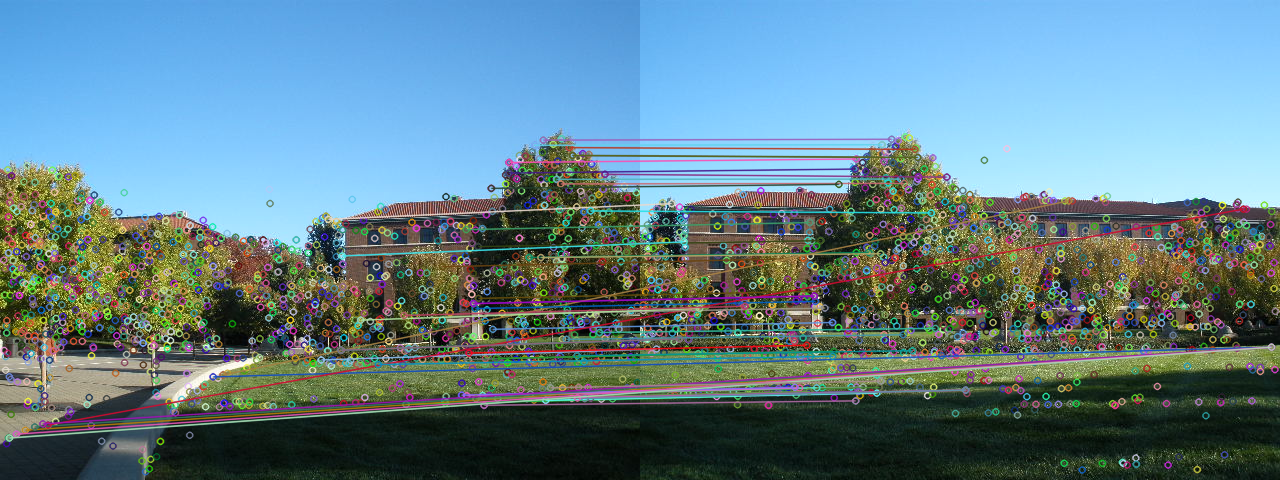

In [80]:
# Visualizing the matches
match1_img = draw_match(img1, img2)
cv2_imshow(match1_img)

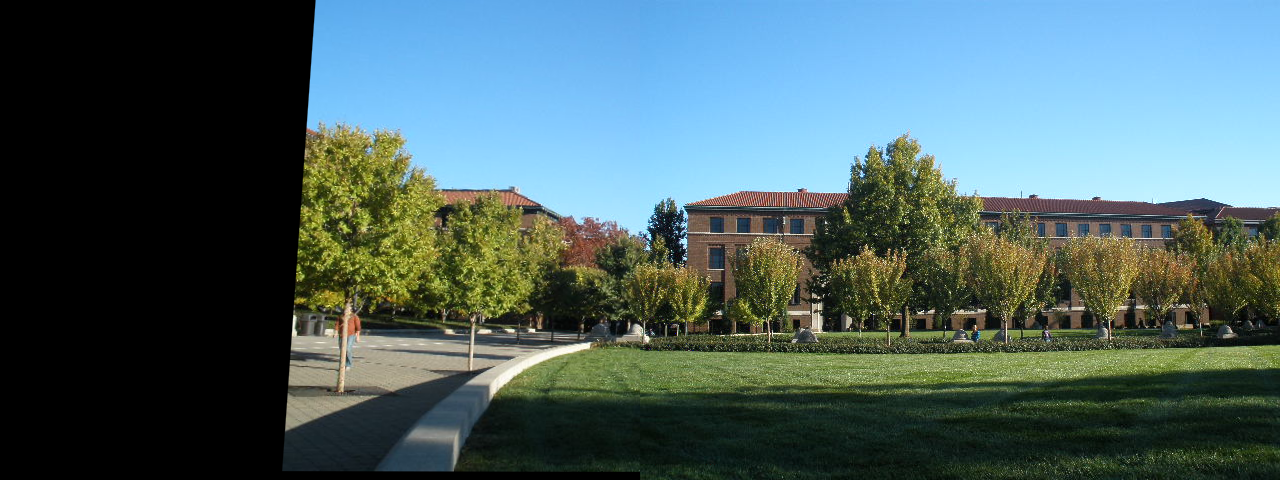

In [ ]:
stitch1 = ProcessInitial(img1, blank_canvas1)

cv2_imshow(stitch1)
cv2.waitKey(0)
cv2.destroyAllWindows()

### Defining Blank Canvas 2

We define a blank canvas of double the width and same height and paste Image 3 on the left half of the canvas

In [73]:
blank_canvas2 = np.zeros((h1,w1*2,3), np.uint8)
blank_canvas2[0:h1,0:w1] = img3

# cv2_imshow(blank_canvas2)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

### Performing the Stitching between Image3 and Image4

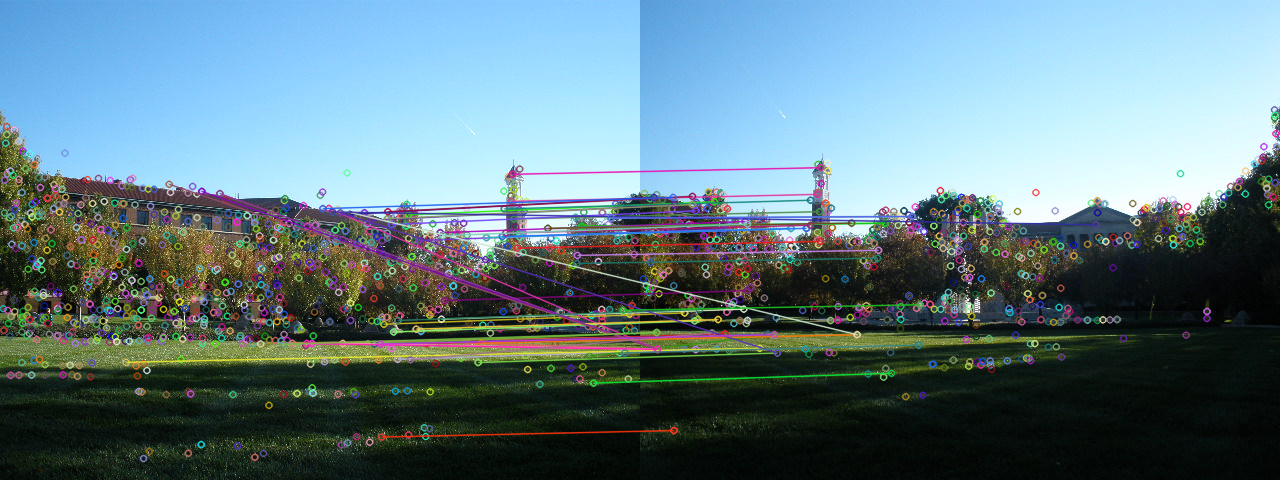

In [76]:
# Visualizing the matches
match2_img = draw_match(img3, img4)
cv2_imshow(match2_img)

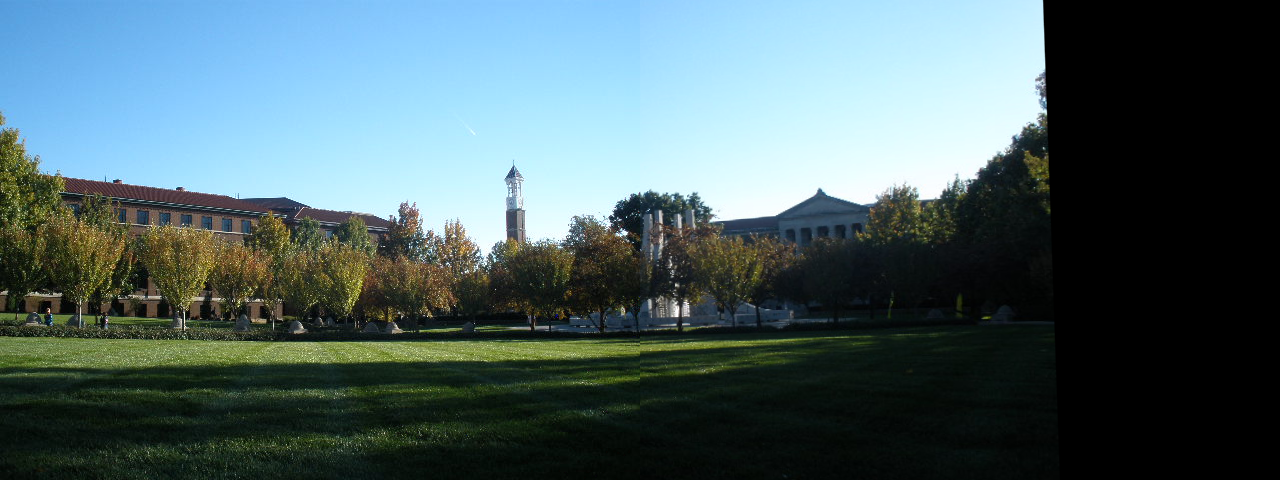

In [ ]:
stitch2 = ProcessInitial(img4, blank_canvas2)

cv2_imshow(stitch2)
cv2.waitKey(0)
cv2.destroyAllWindows()

### Defining the function for Final Image Stitching

We have to define another function because the final image size would be 4xImg Width and same height and so the warp perspective size should match with the destination size.

In [ ]:
def ProcessFinal(img1, img2):
    sift = cv2.SIFT_create()

    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    ig1_kp = cv2.drawKeypoints(img1, kp1, None)
    ig2_kp = cv2.drawKeypoints(img2, kp2, None)

    num_matches = 80

    index_params = dict(algorithm=0, trees=5)
    search_params = dict(checks=100)
    flann = cv2.FlannBasedMatcher(index_params, search_params)


    matches_flann = flann.match(des1, des2)
    matches_flann = sorted(matches_flann, key=lambda x: x.distance)



    src_points = np.float32([kp1[m.queryIdx].pt for m in matches_flann]).reshape(-1, 1, 2)
    dst_points = np.float32([kp2[m.trainIdx].pt for m in matches_flann]).reshape(-1, 1, 2)

    homography, mask = cv2.findHomography(src_points, dst_points, cv2.RANSAC, 10.0)


    warped_img = cv2.warpPerspective(img1, homography,(img2.shape[1], img2.shape[0]))

    output_final = blend_func(img2, warped_img)

    return output_final

### Creating a Final Blank Canvas

We define the blank canvas and paste the **Stitch1** image onto the left half of the canvas and then perform the stitching operation using  **Stitch2**

In [81]:
wf = stitch1.shape[1]
hf = stitch1.shape[0]

blank_final = np.zeros((hf,wf*2,3), np.uint8)
blank_final[0:hf, 0:wf] = stitch1

# cv2_imshow(blank_final)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

### Performing Final Image Stitching

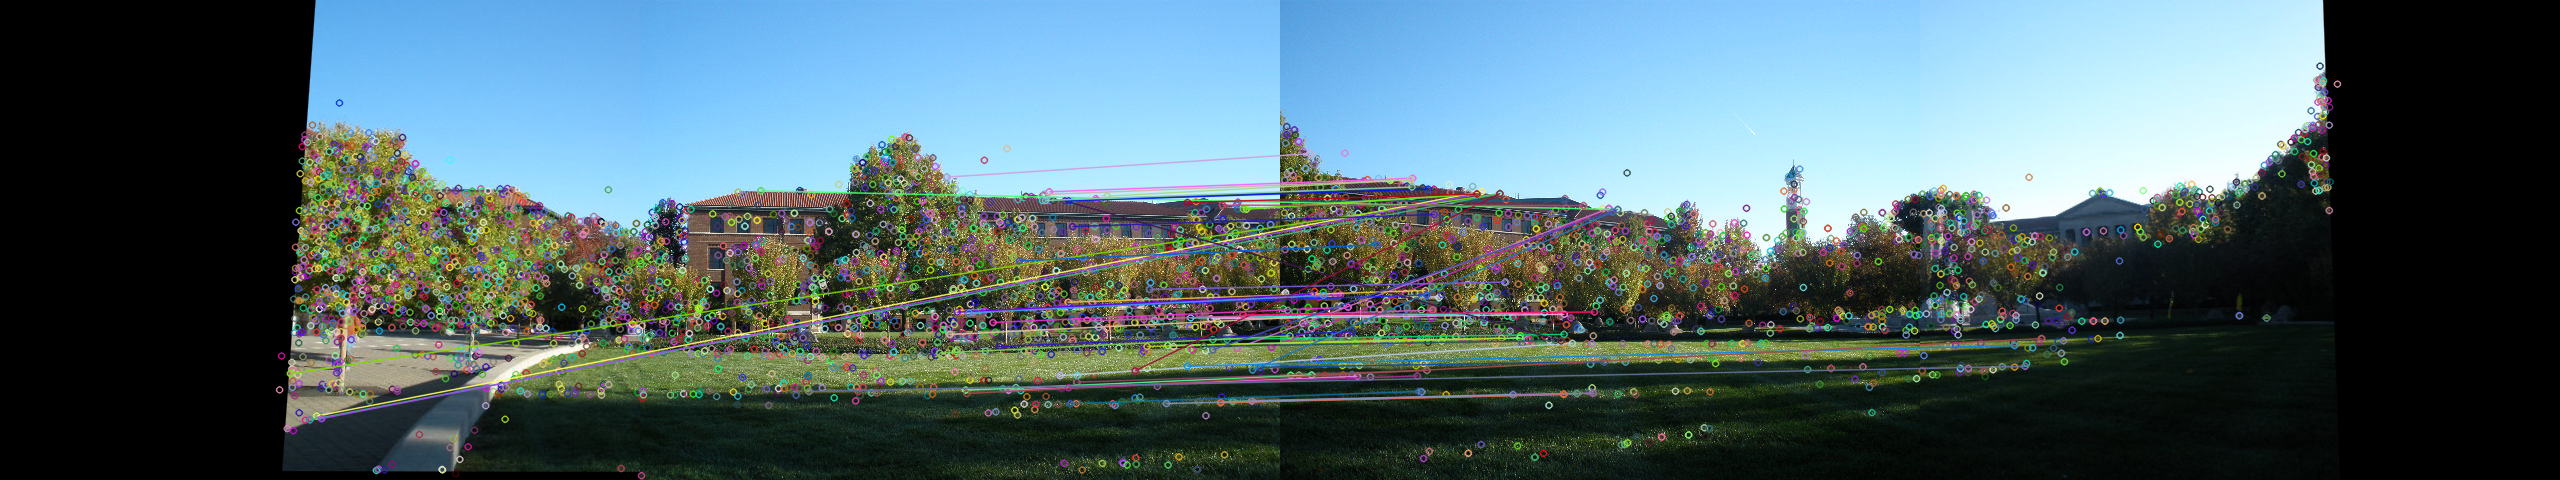

In [78]:
# Visualizing the matches
match3_img = draw_match(stitch1, stitch2)
cv2_imshow(match3_img)

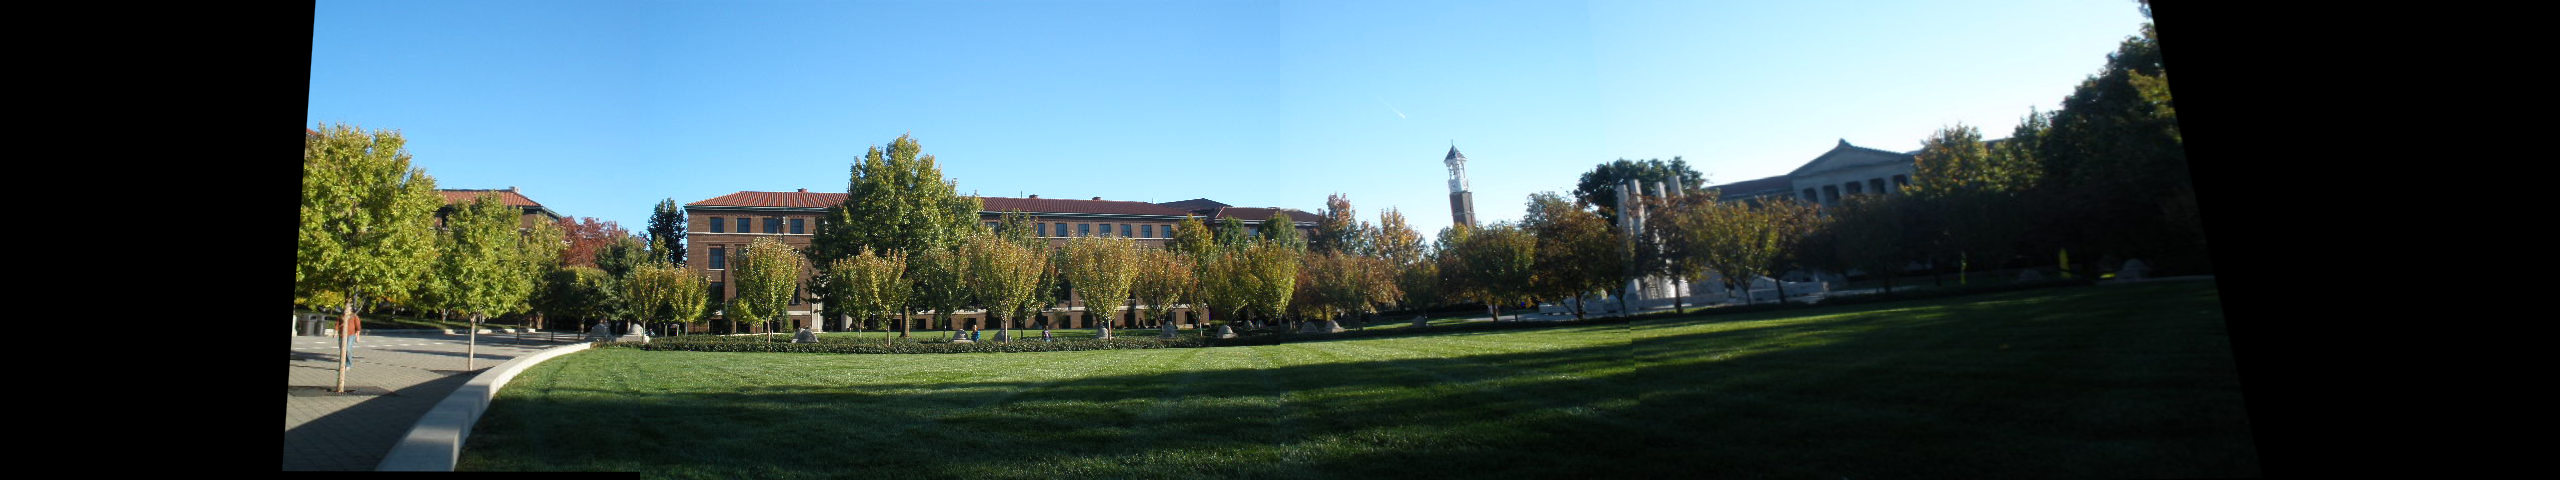

In [79]:
final_img = ProcessFinal(stitch2, blank_final)
# imS = cv2.resize(final_img, (1280, 240))


cv2_imshow(final_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

### Cropping the Image for Better Orientation

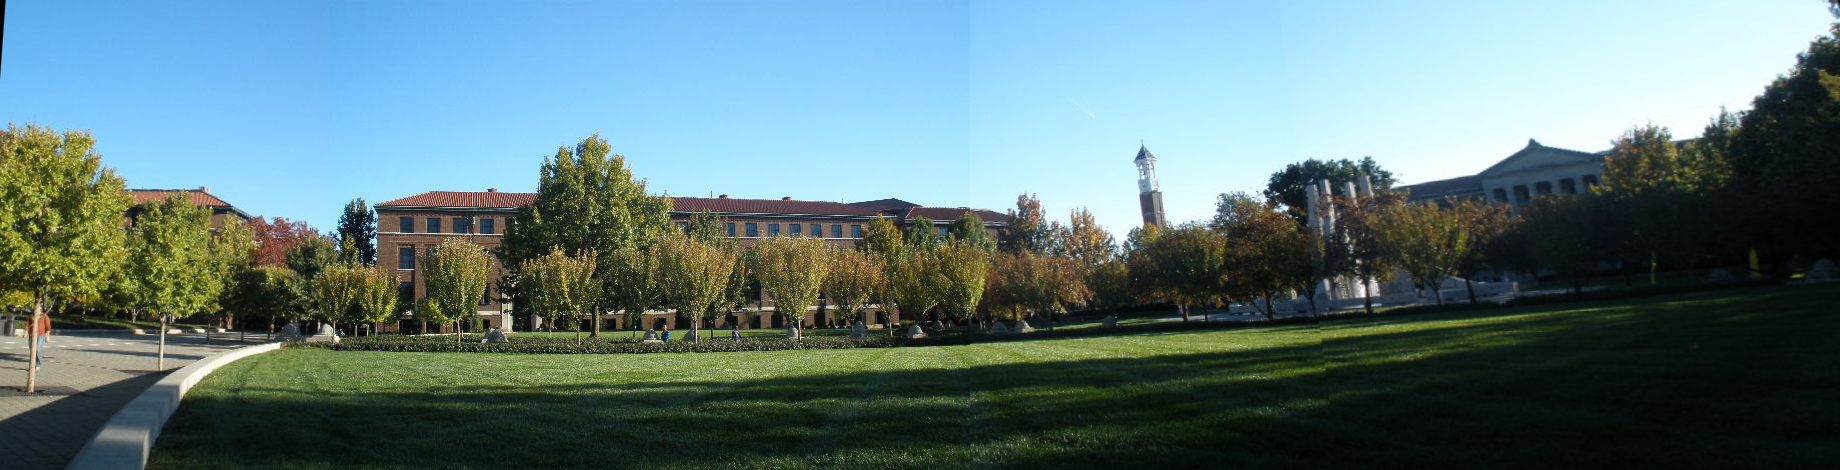

In [ ]:
cropped_image = final_img[0:470, 310:2150]

cv2_imshow(cropped_image)